# New section

In [ ]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
from sklearn.preprocessing import LabelEncoder
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np


In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available device: {device}')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

In [ ]:
image_path= []
labels= []

for i in os.listdir('/root/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1/afhq'):
  for label in os.listdir(f'/root/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1/afhq/{i}'):
    for image in os.listdir(f'/root/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1/afhq/{i}/{label}'):
      image_path.append(f'/root/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1/afhq/{i}/{label}/{image}')
      labels.append(label)



In [ ]:
df=pd.DataFrame(zip(image_path,labels),columns=['image_path','labels'])
print(df['labels'].unique())

['wild' 'dog' 'cat']


In [ ]:
df.head()

,image_path,labels
0,/root/.cache/kagglehub/datasets/andrewmvd/anim...,wild
1,/root/.cache/kagglehub/datasets/andrewmvd/anim...,wild
2,/root/.cache/kagglehub/datasets/andrewmvd/anim...,wild
3,/root/.cache/kagglehub/datasets/andrewmvd/anim...,wild
4,/root/.cache/kagglehub/datasets/andrewmvd/anim...,wild


In [ ]:
train = df.sample(frac=0.7)
test=df.drop(train.index)

val=test.sample(frac=0.5)
test=df.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(13710, 2)


In [ ]:
le = LabelEncoder()
le.fit_transform(df['labels'])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [ ]:
class customImageDataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe = dataframe
    self.transform=transform
    self.labels= torch.tensor(le.transform(dataframe['labels'])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]

    image= Image.open(img_path).convert('RGB')

    if self.transform:
       image=self.transform(image).to(device)


       return image,label

In [ ]:
train_dataset = customImageDataset(dataframe=train,transform=transform)
val_dataset=customImageDataset(dataframe=val, transform=transform)
test_dataset=  customImageDataset(dataframe=test, transform=transform)

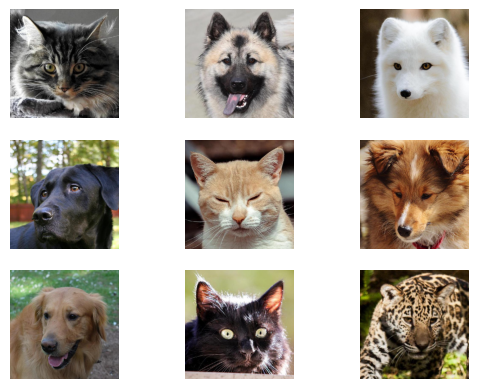

In [ ]:
n_rows = 3
n_columns = 3
# Use plt.subplots() to create a figure and an array of axes
f, axar = plt.subplots(n_rows , n_columns)
for row in range(n_rows):
  for coloumns in range(n_columns):
    image =Image.open(df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
    axar[row,coloumns].imshow(image)
    axar[row,coloumns].axis('off')
plt.show()

In [ ]:
lr= 1e-4
batch_size = 16
epoches  =10

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_loader =DataLoader(test_dataset,batch_size=batch_size,shuffle=True)


In [ ]:
class nnn(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(3,32,3,padding=1)
    self.conv2=nn.Conv2d(32,64,3,padding=1)
    self.conv3=nn.Conv2d(64,128,3,padding=1)
    self.pool=nn.MaxPool2d(2,2)
    self.relu=nn.ReLU()
    self.flatten=nn.Flatten()
    self.linear=nn.Linear(128*16*16,128)
    self.output=nn.Linear(128,len(df['labels'].unique()))

  def forward(self,x):
    x=self.relu(self.pool(self.conv1(x)))
    x=self.relu(self.pool(self.conv2(x)))
    x=self.relu(self.pool(self.conv3(x)))
    x=self.flatten(x)
    x=self.linear(x)
    x=self.output(x)
    return x
model=nnn().to(device)


In [ ]:
loss_fn=nn.CrossEntropyLoss()
optimizer  = Adam(model.parameters(),lr=lr)

In [ ]:
total_acc_train_plot,total_loss_train_plot =[],[]
total_acc_val_plot , total_loss_val_plot = [],[]

for epoch in range(epoches):
  total_loss_train,total_acc_train= 0,0

  model.train()

  for train_dataset in train_loader:
    # Corrected typo from 'lables' to 'labels'
    inputs , labels = train_dataset
    outputs = model(inputs)
    # Using the correctly named 'labels' tensor
    batch_loss = loss_fn(outputs,labels)
    total_loss_train +=batch_loss.item()
    # Using the correctly named 'labels' tensor
    total_acc_train += (outputs.argmax(1)==labels).sum().item()

  total_loss_train_plot.append(total_loss_train/len(train_loader))
  # The length calculation should be based on the number of samples, not batches
  total_acc_train_plot.append(total_acc_train/len(train_dataset))

  total_loss_val,total_acc_val=0,0
  model.eval() # Set the model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
    for val_dataset in val_loader:
      # Variables are correctly unpacked as inputs, labels
      inputs,labels=  val_dataset
      outputs= model(inputs)
      # Corrected typo from 'lables' to 'labels'
      batch_loss= loss_fn(outputs,labels)
      total_loss_val += batch_loss.item()
      # Corrected typo from 'lables' to 'labels'
      total_acc_val += (outputs.argmax(1)==labels).sum().item()

  total_loss_val_plot.append(total_loss_val/len(val_loader))
  # The length calculation should be based on the number of samples, not batches
  total_acc_val_plot.append(total_acc_val/len(val_dataset))


  print(f'''Epoch{epoch+1} :  train loss:{total_loss_train:.3f}, Acc:{100*total_acc_train/len(train_dataset):.2f}
   val loss:{total_loss_val:.3f} , Acc:{100*total_acc_val/len(val_dataset):.2f}''')




Epoch1 :  train loss:775.639, Acc:184550.00
   val loss:167.040 , Acc:38000.00
Epoch2 :  train loss:775.640, Acc:184550.00
   val loss:167.058 , Acc:38000.00
Epoch3 :  train loss:775.643, Acc:184550.00
   val loss:167.009 , Acc:38000.00
Epoch4 :  train loss:775.637, Acc:184550.00
   val loss:167.039 , Acc:38000.00
Epoch5 :  train loss:775.644, Acc:184550.00
   val loss:167.031 , Acc:38000.00
Epoch6 :  train loss:775.643, Acc:184550.00
   val loss:167.018 , Acc:38000.00
Epoch7 :  train loss:775.640, Acc:184550.00
   val loss:167.010 , Acc:38000.00
Epoch8 :  train loss:775.639, Acc:184550.00
   val loss:167.012 , Acc:38000.00
Epoch9 :  train loss:775.638, Acc:184550.00
   val loss:167.021 , Acc:38000.00
Epoch10 :  train loss:775.642, Acc:184550.00
   val loss:167.010 , Acc:38000.00


In [ ]:
with torch.inference_mode():
  total_loss_test = 0
  total_acc_test = 0

  for inputs,labels in test_loader:
    prediction = model(inputs)
    acc=(torch.argmax(prediction, axis=1)==labels).sum().item()
    total_acc_test +=acc
    test_loss =loss_fn(prediction,labels)
    total_loss_test = test_loss.item()

print(f'acc score: {round((total_acc_test/test_dataset.__len__())*100,4)} and loss is:{round(total_loss_test/1000,4)}')




acc score: 32.6623 and loss is:0.0011
